In [1]:
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import os
import logging
from matplotlib import pyplot as plt

In [2]:
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '0'
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
logging.getLogger('tensorflow').setLevel(logging.ERROR)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Loading the training dataset

In [3]:
with open(f'data/x_train_sample.npy', 'rb') as f:
    X_train = np.load(f, allow_pickle=True)
with open(f'data/y_train_sample.npy', 'rb') as f:
    Y_train = np.load(f, allow_pickle=True)

#### Setting Initial hyper-parameters
`output_classes` refers to the range of notes to be predicted/generated
`seq_len` refers to the size of each sample x

In [4]:
output_classes = 120
seq_len = 50

#### Normalize the training data
![](https://www.oreilly.com/library/view/regression-analysis-with/9781788627306/assets/ffb3ac78-fd6f-4340-aa92-cde8ae0322d6.png)
Using the min-max normalization, the dataset is normalized.

In [5]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1).astype("float32") / (output_classes-1)

# WaveNet Implementation
This is the researcher's own implementation of Google DeepMind's WaveNet architecture. You can check the original paper of [here](https://arxiv.org/pdf/1609.03499.pdf).

In [6]:
class DilatedCausalConvolution1D(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate):
        super(DilatedCausalConvolution1D, self).__init__()
        self.conv1D = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding="causal")
        self.index_of_ignored_data = (kernel_size - 1) * dilation_rate

    def call(self, x, training=False):
        x = self.conv1D(x, training=training)
        return x[:, self.index_of_ignored_data:]


class ResidualBlock(layers.Layer):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation_rate):
        super(ResidualBlock, self).__init__()
        self.dilated_causal_convolution = DilatedCausalConvolution1D(res_channels, kernel_size,
                                                                     dilation_rate=dilation_rate)
        self.residual_conv1D = layers.Conv1D(filters=res_channels, kernel_size=1)
        self.skip_conv1D = layers.Conv1D(filters=skip_channels, kernel_size=1)

    def call(self, input_x, skip_size, training=False):
        x = self.dilated_causal_convolution(input_x, training=training)
        tanh_result = keras.activations.tanh(x)
        sigmoid_result = keras.activations.sigmoid(x)
        x = tanh_result * sigmoid_result
        residual_output = self.residual_conv1D(x)
        residual_output = residual_output + input_x[:, -residual_output.shape[1]:]
        skip_connection_output = self.skip_conv1D(x)
        skip_connection_output = skip_connection_output[:, -skip_size:]
        return residual_output, skip_connection_output


class StacksResidualBlocks(layers.Layer):
    def __init__(self, residual_channels, skip_channels, kernel_size, stack_size, layer_size):
        super(StacksResidualBlocks, self).__init__()
        build_dilation_function = self.build_dilation
        dilations = build_dilation_function(stack_size, layer_size)
        self.residual_blocks = []

        for stack_level, dilations_per_stack in enumerate(dilations):
            for layer_level, dilation_rate in enumerate(dilations_per_stack):
                residual_block = ResidualBlock(residual_channels, skip_channels, kernel_size, dilation_rate)
                self.residual_blocks.append(residual_block)

    def build_dilation(self, stack_size, layer_size):
        stacks_dilations = []
        for stack in range(stack_size):
            dilations = []
            for layer in range(layer_size):
                dilations.append(2 ** layer)
            stacks_dilations.append(dilations)
        return stacks_dilations

    def call(self, x, skip_size, training=False):
        residual_output = x
        skip_connection_outputs = []
        for residual_block in self.residual_blocks:
            residual_output, skip_connection_output = residual_block(residual_output, skip_size)
            skip_connection_outputs.append(skip_connection_output)
        return residual_output, tf.convert_to_tensor(skip_connection_outputs)


class DenseLayer(layers.Layer):
    def __init__(self, channel, num_classes):
        super(DenseLayer, self).__init__()
        self.conv1D = layers.Conv1D(filters=channel, kernel_size=1)
        self.dense = layers.Dense(num_classes)
        self.flatten = layers.Flatten()

    def call(self, skip_connection_outputs, training=False):
        x = tf.reduce_mean(skip_connection_outputs, 0)
        x = keras.activations.relu(x)
        x = self.conv1D(x, training=training)
        x = keras.activations.relu(x)
        x = self.conv1D(x, training=training)
        x = self.flatten(x)
        x = self.dense(x)
        x = keras.activations.softmax(x)
        return x


class WaveNet(keras.Model):
    def __init__(self, input_channels, output_channels, kernel_size, stack_size, layer_size, num_classes):
        super(WaveNet, self).__init__()
        self.kernel_size = kernel_size
        self.stack_size = stack_size
        self.layer_size = layer_size
        self.causal_conv1D = DilatedCausalConvolution1D(input_channels, kernel_size=1, dilation_rate=1)
        self.stack_residual_blocks = StacksResidualBlocks(input_channels, output_channels, kernel_size, stack_size,
                                                          layer_size)
        self.classifier = DenseLayer(output_channels, num_classes)

    def calculate_receptive_field(self):
        return np.sum([(self.kernel_size - 1) * (2 ** level) for level in range(self.layer_size)] * self.stack_size)

    def calculate_skip_size(self, x):
        return x.shape[1] - self.calculate_receptive_field()

    def call(self, input_x, training=False):
        x = self.causal_conv1D(input_x)
        skip_size = self.calculate_skip_size(x)
        _, skip_connection_outputs = self.stack_residual_blocks(input_x, skip_size=skip_size, training=training)
        x = self.classifier(skip_connection_outputs)
        return x

    def model(self):
        x = keras.Input(shape=(seq_len, 1))
        return keras.Model(inputs=[x], outputs=self.call(x))

#### More hyper-parameter settings

In [7]:
residual_channel = 128
skip_channel = 256
kernel_size = 2
stack_size = 2
layer_size = 3

model = WaveNet(residual_channel, skip_channel, kernel_size, stack_size, layer_size, output_classes)

#### Training parameters

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)


#### Model summary

In [9]:
print(model.model().summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 stacks_residual_blocks (Sta  ((None, 36, 128),        462080    
 cksResidualBlocks)           (6, None, 35, 256))                
                                                                 
 dense_layer (DenseLayer)    (None, 120)               1141112   
                                                                 
Total params: 1,603,192
Trainable params: 1,603,192
Non-trainable params: 0
_________________________________________________________________
None


#### Model fitting

In [10]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=2)

Epoch 1/15
197/197 - 15s - loss: 3.3900 - accuracy: 0.1231 - 15s/epoch - 76ms/step
Epoch 2/15
197/197 - 5s - loss: 2.7104 - accuracy: 0.2472 - 5s/epoch - 27ms/step
Epoch 3/15
197/197 - 5s - loss: 2.1556 - accuracy: 0.3839 - 5s/epoch - 27ms/step
Epoch 4/15
197/197 - 5s - loss: 1.5638 - accuracy: 0.5472 - 5s/epoch - 27ms/step
Epoch 5/15
197/197 - 5s - loss: 1.1281 - accuracy: 0.6759 - 5s/epoch - 27ms/step
Epoch 6/15
197/197 - 5s - loss: 0.8199 - accuracy: 0.7716 - 5s/epoch - 27ms/step
Epoch 7/15
197/197 - 5s - loss: 0.5955 - accuracy: 0.8385 - 5s/epoch - 27ms/step
Epoch 8/15
197/197 - 5s - loss: 0.4824 - accuracy: 0.8769 - 5s/epoch - 27ms/step
Epoch 9/15
197/197 - 5s - loss: 0.3556 - accuracy: 0.9179 - 5s/epoch - 27ms/step
Epoch 10/15
197/197 - 5s - loss: 0.3518 - accuracy: 0.9135 - 5s/epoch - 27ms/step
Epoch 11/15
197/197 - 5s - loss: 0.2951 - accuracy: 0.9351 - 5s/epoch - 27ms/step
Epoch 12/15
197/197 - 5s - loss: 0.2382 - accuracy: 0.9505 - 5s/epoch - 27ms/step
Epoch 13/15
197/197 - 5

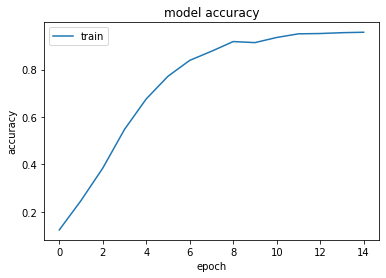

In [11]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

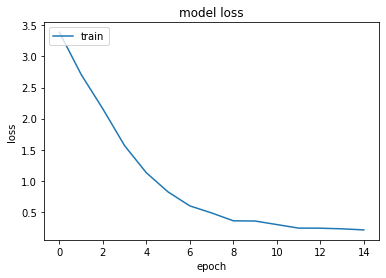

In [12]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()